# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
np.random.seed = 42

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import haversine_distances

import tensorflow as tf
import tensorflow_hub as hub
from collections import Counter

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from scipy.spatial import distance
from sklearn_extra.cluster import KMedoids

from sklearn.base import BaseEstimator, TransformerMixin
import copy
from sklearn.cluster import AgglomerativeClustering
import geopandas as gpd
from scipy.cluster import hierarchy

In [55]:
df = pd.read_csv('./DATA/google_places_data.csv')

# Feature Engineering

#### Deleting duplicated rows

In [56]:
df = df.drop_duplicates(subset=['business_id'])

#### Deleting NA values

In [57]:
df = df.dropna(how='any').reset_index(drop = True)

#### Outliers

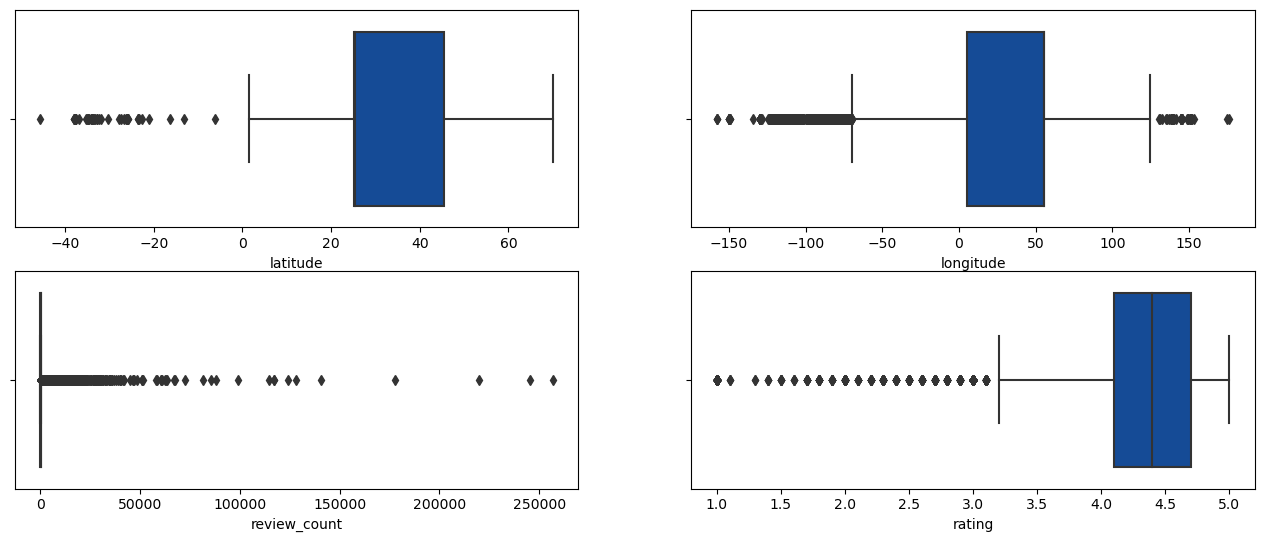

In [5]:
plt.figure(figsize = (16,13))

for i, col in enumerate(['latitude', 'longitude', 'review_count', 'rating']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = df, color='#0047AB')
plt.show()

##### Cutting off review_count

In [6]:
review_count_count = df["review_count"].value_counts().reset_index(name='count')
review_count_count = review_count_count[review_count_count['count'] > 100]
review_count_count

,review_count,count
0,32.0,2734
1,1.0,1054
2,2.0,713
3,3.0,543
4,4.0,412
5,5.0,334
6,6.0,255
7,7.0,252
8,8.0,236
9,9.0,218


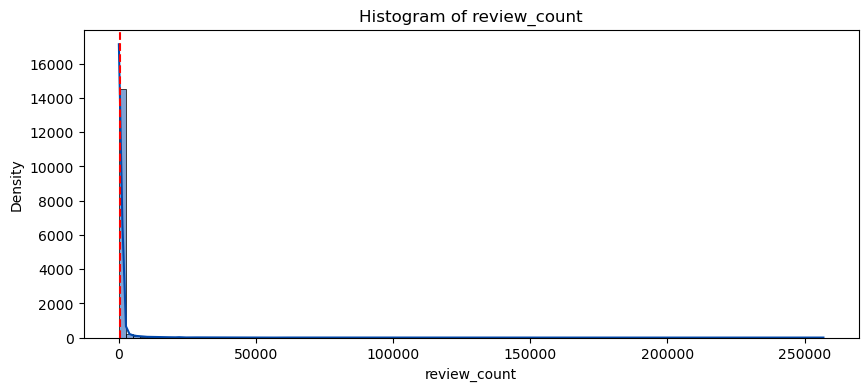

Value above which highest 10% of the data falls: 565.0


In [7]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')

highest_10_percent = df['review_count'].quantile(0.90)
plt.axvline(x=highest_10_percent, color='red', linestyle='--')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()
print("Value above which highest 10% of the data falls:", highest_10_percent)

In [8]:
df.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent

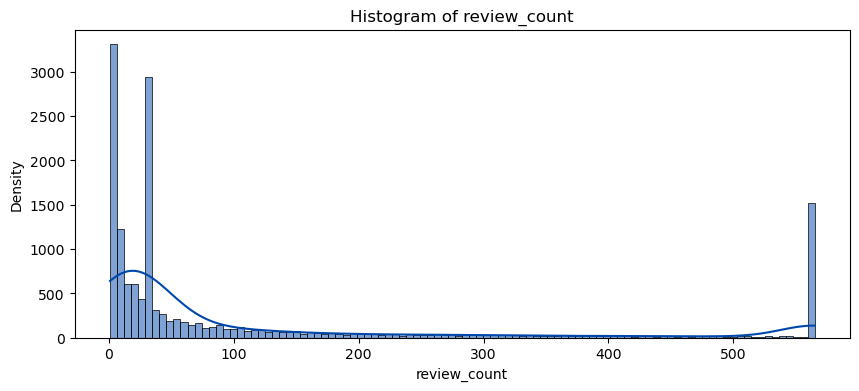

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()

#### Column removal

In [10]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
business_id,15103
phone_number,11277
name,14187
full_address,14737
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7529


In [11]:
df = df.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])

Some categorical columns have values that are mostly unique to each record in the dataset. As a result, they will not be valuable for our model and we decided to remove them. 

Removed columns: 
* business_id
* phone_number	
* name	
* full_address 
* place_id 
* place_link	

In [12]:
df = df.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])

From the EDA stage, we know that the columns related to business operating hours are highly correlated with each other, so we have decided to remove these columns as well.

In [13]:
df = df.drop(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The opening time is not important for our business problem, so we will delete all columns related to opening time.

In [14]:
df = df.drop(columns=['geo_cluster'])

We decided to remove the geo_cluster column, which resulted from a previous clustering performed on the data.

In [15]:
df = df.drop(columns=['state'])

The "state" column indicates whether a given business is open or closed at the time of data collection and how much time remains until this changes. This column is not relevant for clustering, so we have decided to remove it.

In [16]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7529
types,4082
city,1964
verified,2
country,194


##### website

In [17]:
df['has_website'] = df['website'].apply(lambda x: 0 if x == 'Unknown' else 1)

In [18]:
has_website_count = df["has_website"].value_counts().reset_index(name='count')
has_website_count

,has_website,count
0,1,8864
1,0,6239


##### country

In [19]:
def extract_country(city_country):
    if ',' in city_country:
        return city_country.split(',')[1].strip()
    if '-' in city_country:
        return city_country.split('-')[1].strip() 
    else:
        return city_country

def replace_two_letter_words(text):
    pattern = r'\b[A-Z]{2}\b'
    result = re.sub(pattern, 'USA', text)
    return result

In [20]:
df['country'] = df['country'].apply(lambda x: extract_country(x))
df['country'] = df['country'].apply(lambda x: replace_two_letter_words(x))
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9516
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
...,...,...
76,North Macedonia,1
77,Türkiye,1
78,Ghana,1
79,Latvia,1


In [21]:
category_counts = df['country'].value_counts()
rare_categories = category_counts[category_counts < 10].index
df['country'] = df['country'].apply(lambda x: 'Other' if x in rare_categories or x == 'Unknown' else x)
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9516
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
5,Other,206
6,Canada,90
7,Belgium,53
8,Russia,40
9,Australia,26


In [22]:
df = df.drop(columns=['country'])

This is still too many category (country) so we decide to not use column country as well as column city, but we will use more global column continent.

##### timezone

In [23]:
df['timezone']

0           Asia/Dubai
1           Asia/Dubai
2          Asia/Muscat
3        Europe/London
4        Europe/London
             ...      
15098       Asia/Dubai
15099       Asia/Dubai
15100       Asia/Dubai
15101       Asia/Dubai
15102       Asia/Dubai
Name: timezone, Length: 15103, dtype: object

In [24]:
df['continent'] = df['timezone'].str.split('/').str[0]

In [25]:
df['continent'] = df['continent'].apply(lambda x: 'America' if x == 'Pacific' else x)
continent_count = df["continent"].value_counts().reset_index(name='count')
continent_count

,continent,count
0,Asia,9454
1,Europe,3612
2,America,1994
3,Australia,27
4,Africa,16


##### types

In [26]:
df['types']

0                                                   Museum
1                                                   Museum
2              National museum, Museum, Tourist attraction
3        Science museum, Heritage museum, Museum, Touri...
4              Open air museum, Museum, Tourist attraction
                               ...                        
15098                                    Van rental agency
15099                                    Car rental agency
15100                                  Car leasing service
15101                                    Car rental agency
15102                                    Car rental agency
Name: types, Length: 15103, dtype: object

In [27]:
def preprocess_text(text):
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [28]:
df['cleaned_types'] = df['types'].apply(lambda x: preprocess_text(x))
df['cleaned_types']

0                                                   museum
1                                                   museum
2                national museum museum tourist attraction
3        science museum heritage museum museum tourist ...
4                open air museum museum tourist attraction
                               ...                        
15098                                    van rental agency
15099                                    car rental agency
15100                                  car leasing service
15101                                    car rental agency
15102                                    car rental agency
Name: cleaned_types, Length: 15103, dtype: object

#### TfidfVectorizer

In [29]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned_types'])

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [31]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [32]:
# assign clusters and pca vectors to our dataframe 
df['cluster_type'] = clusters
df['x0'] = x0
df['x1'] = x1
df[['types', 'cluster_type', 'x0', 'x1']]

,types,cluster_type,x0,x1
0,Museum,3,-0.046814,0.021842
1,Museum,3,-0.046814,0.021842
2,"National museum, Museum, Tourist attraction",3,-0.075546,0.033758
3,"Science museum, Heritage museum, Museum, Touri...",3,-0.073315,0.032917
4,"Open air museum, Museum, Tourist attraction",3,-0.078986,0.034703
...,...,...,...,...
15098,Van rental agency,2,-0.244451,-0.307337
15099,Car rental agency,2,-0.337516,-0.448333
15100,Car leasing service,0,-0.113483,-0.096993
15101,Car rental agency,2,-0.337516,-0.448333


In [33]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
pharmacy,station,bank,salon,laundry,park,bakery,atm,service,hotel

Cluster 1
coffee,shop,pizza,indian,delivery,fast,bar,food,cafe,restaurant

Cluster 2
tour,insurance,used,estate,real,dealer,rental,travel,car,agency

Cluster 3
amusement,state,theme,aquarium,art,zoo,park,museum,attraction,tourist

Cluster 4
pet,grocery,hardware,jewelry,electronics,furniture,shoe,book,clothing,store


#### Universal Sentence Encoder (USE)

In [34]:
# pip install tensorflow tensorflow-hub scikit-learn

In [35]:
# Load the Universal Sentence Encoder model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_text(text, model):
    embeddings = model([text])
    return embeddings.numpy().squeeze()

embeddings = []
for text in df['cleaned_types']:
    embeddings.append(embed_text(text, use_model))

X = np.array(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

def get_top_keywords(n_terms):
    """This function returns the top keywords for each cluster."""
    df['cluster'] = clusters
    for i in range(len(set(clusters))):
        cluster_texts = df[df['cluster'] == i]['cleaned_types']
        all_words = ' '.join(cluster_texts).lower()
        all_words = re.findall(r'\b\w+\b', all_words)  
        common_words = Counter(all_words).most_common(n_terms)
        top_keywords = [word for word, count in common_words]
        print(f'\nCluster {i}')
        print(', '.join(top_keywords))

get_top_keywords(10)


Cluster 0
agency, estate, real, rental, travel, insurance, car, service, establishment, contractor

Cluster 1
hotel, restaurant, atm, station, laundry, bank, library, park, bus, service

Cluster 2
store, salon, shop, pharmacy, bakery, book, shoe, dealer, clothing, beauty

Cluster 3
store, service, shop, restaurant, dealer, car, clothing, supplier, repair, auto

Cluster 4
tourist, attraction, park, museum, amusement, center, casino, art, zoo, tour


We have decided to use the TfidfVectorizer method based on a comparison of the top words in each group. TfidfVectorizer better characterizes the types of places.

#####  latitude and longitude

##### KMedoids

In [63]:
def metrics_plots(X, max_k=10):
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    
    
    for k in range(2, max_k):
        
        kmedoids = KMedoids(n_clusters=k, random_state=0, metric='haversine')      
        kmedoids.fit(X)

        labels = kmedoids.labels_
        
        silhouette_scores.append(silhouette_score(X, labels, metric='haversine'))
        calinski_harabasz_scores.append(calinski_harabasz_score(X, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, labels))
        

    list_scores = [silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores] 
    list_title = ['silhouette_scores', 'calinski_harabasz_scores', 'davies_bouldin_scores'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

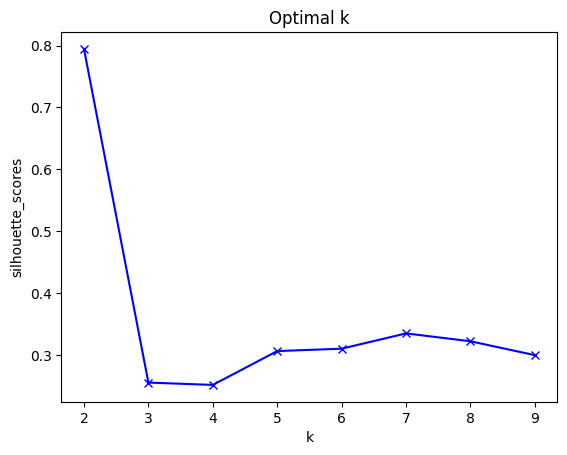

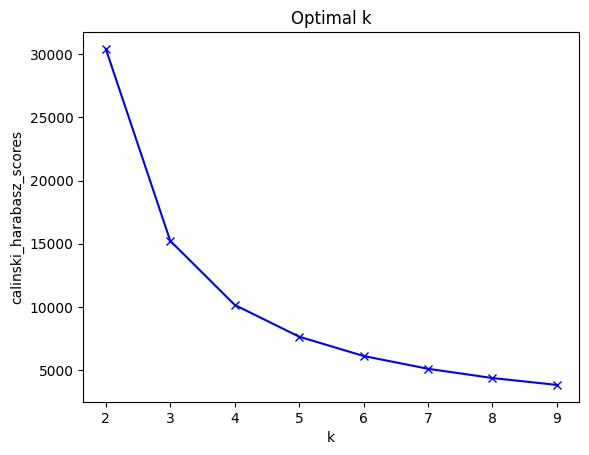

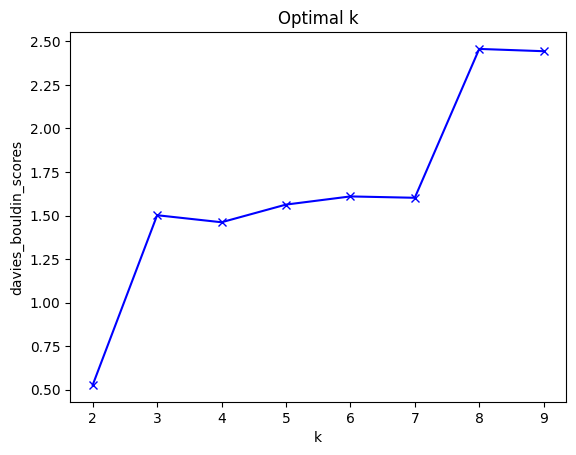

In [65]:
df_geografics  = df[["longitude", "latitude"]]
df_geografics['latitude_rad'] = np.radians(df_geografics['latitude'])
df_geografics['longitude_rad'] = np.radians(df_geografics['longitude'])
df_geografics_rad = df_geografics.drop(columns=['longitude', 'latitude'])
metrics_plots(df_geografics_rad, max_k=10)

In [49]:
kmedoids = KMedoids(n_clusters=4, random_state=0, metric='haversine')
kmedoids.fit(df_geografics_rad)
y_kmedoids = kmedoids.predict(df_geografics_rad)

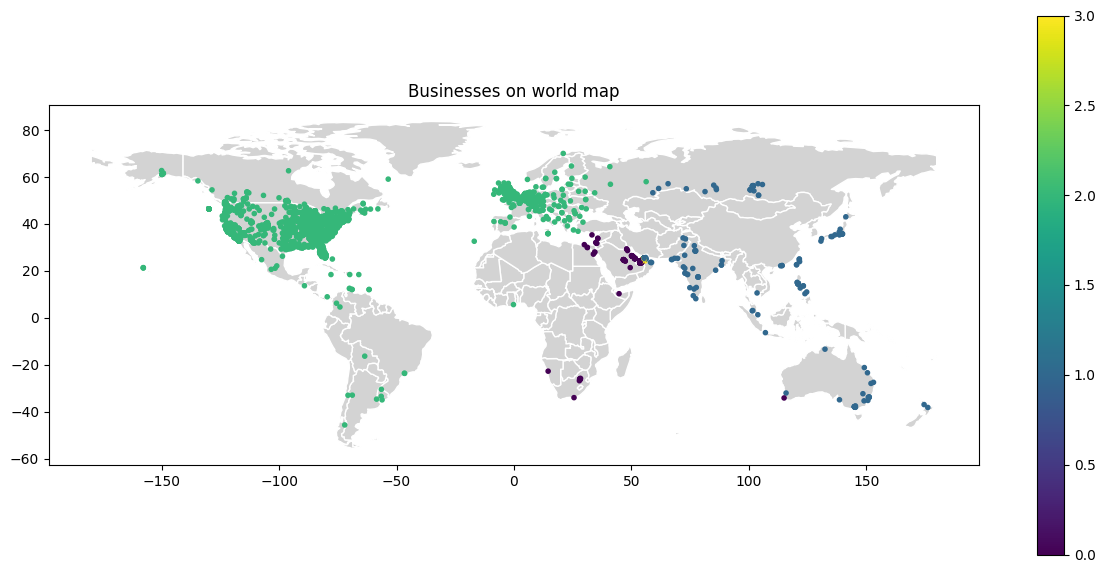

In [50]:
gdf = gpd.GeoDataFrame(df_geografics, geometry=gpd.points_from_xy(df_geografics['longitude'], df_geografics['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != "Antarctica")]

world.plot(figsize=(15, 7), color='lightgray', edgecolor='white')

gdf.plot(ax=plt.gca(), marker='o', column=y_kmedoids, markersize=9, legend = True)

plt.title('Businesses on world map')
plt.show()

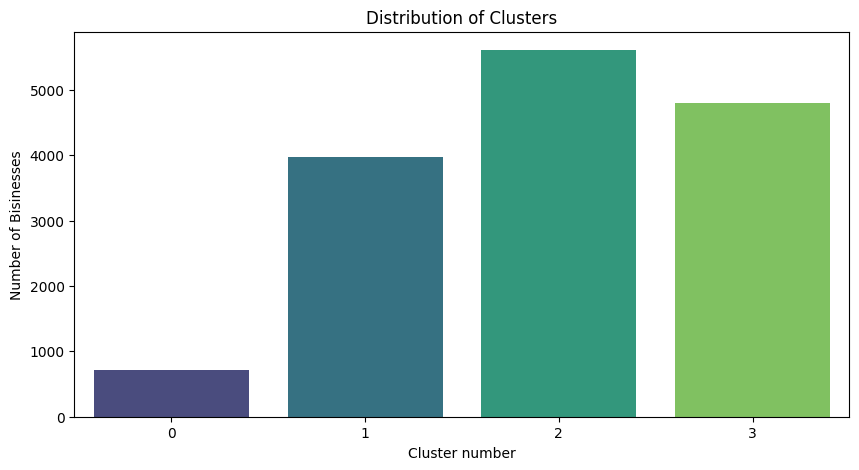

In [51]:
df = pd.DataFrame({"labels": y_kmedoids})
value_counts = df["labels"].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster number')
plt.ylabel('Number of Bisinesses')
plt.show()

### Train, Validation and Test Sets

In [69]:
df = pd.read_csv('./DATA/google_places_data.csv')

In [70]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_val = train_test_split(X_dev, test_size=0.3, random_state=42)

In [77]:
X_train_lat_long = copy.deepcopy(X_train)
X_val_lat_long = copy.deepcopy(X_val)

### Feature engineering pipeline

In [34]:
def dropDuplicatedRows(data):
    data = data.drop_duplicates(subset=['business_id'])
    return data

def dropNAValues(data):
    data = data.dropna(how='any').reset_index(drop = True)
    return data

def hasWebsite(data):
    data['has_website'] = data['website'].apply(lambda x: 0 if x == 'Unknown' else 1)
    data = data.drop(columns=['website'])
    return data

def verifiedToInt(data):
    data['verified'] = data['verified'].astype(int)
    return data

def dropCountryandCityColumn(data):
    data = data.drop(columns=['country'])
    data = data.drop(columns=['city'])
    return data

def continentColumn(data):
    data['continent'] = data['timezone'].str.split('/').str[0]
    data['continent'] = data['continent'].apply(lambda x: 'America' if x == 'Pacific' else x)
    data = data.drop(columns=['timezone'])
    return data

def dropUniqueColumns(data):
    data = data.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])
    return data

def dropDayTimeColumns(data):
    data = data.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening',
                'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    return data

def dropGeoClusterAndState(data):
    data = data.drop(columns=['geo_cluster', 'state'])
    return data

feature_engineering_pipeline = Pipeline([
    ('dropDuplicatedRows', FunctionTransformer(dropDuplicatedRows)),
    ('dropNAValues', FunctionTransformer(dropNAValues)),
    ('hasWebsite', FunctionTransformer(hasWebsite)),
    ('verifiedToInt', FunctionTransformer(verifiedToInt)),
    ('dropCountryandCityColumn', FunctionTransformer(dropCountryandCityColumn)),
    ('continentColumn', FunctionTransformer(continentColumn)),
    ('dropUniqueColumns', FunctionTransformer(dropUniqueColumns)),
    ('dropDayTimeColumns', FunctionTransformer(dropDayTimeColumns)),
    ('dropGeoClusterAndState', FunctionTransformer(dropGeoClusterAndState))
])

In [35]:
X_train = feature_engineering_pipeline.transform(X_train)
X_train

,latitude,longitude,review_count,rating,types,verified,has_website,continent
0,50.114052,8.685846,9.0,4.4,Travel agency,1,1,Europe
1,25.271356,55.316515,20.0,4.7,Mosque,0,0,Asia
2,25.312023,55.456259,35.0,4.3,Bicycle Shop,1,0,Asia
3,25.268352,55.306795,19.0,3.9,Electronics store,1,0,Asia
4,25.204849,55.270783,32.0,4.4,University,0,0,Asia
...,...,...,...,...,...,...,...,...
7420,52.158834,5.382056,32.0,4.4,ATM,0,1,Europe
7421,38.893988,-77.036582,500.0,4.4,"Park, Tourist attraction",0,1,America
7422,25.321703,55.520428,2.0,5.0,Car rental agency,1,0,Asia
7423,25.298560,55.372075,32.0,4.4,Restaurant,1,0,Asia


### Feature engineering pipeline with fitting

In [36]:
class KMedoidsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, random_state=0):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.medoids_model = None

    def fit(self, data, y=None):
        X_geografics = data[["longitude", "latitude"]]
        X_geografics['latitude_rad'] = np.radians(X_geografics['latitude'])
        X_geografics['longitude_rad'] = np.radians(X_geografics['longitude'])
        df_geografics_rad = X_geografics.drop(columns=['longitude', 'latitude'])
        self.medoids_model = KMedoids(n_clusters=self.n_clusters, random_state=self.random_state, metric='haversine')
        self.medoids_model.fit(df_geografics_rad)
        return self

    def transform(self, data, y=None):
        X_geografics = data[["longitude", "latitude"]]
        X_geografics['latitude_rad'] = np.radians(X_geografics['latitude'])
        X_geografics['longitude_rad'] = np.radians(X_geografics['longitude'])
        df_geografics_rad = X_geografics.drop(columns=['longitude', 'latitude'])
        y_kmedoids = self.medoids_model.predict(df_geografics_rad)
        data["cluster_geo"] = y_kmedoids
        return data

class cutOffReviewCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, highest_10_percent=0):
        self.highest_10_percent = highest_10_percent

    def fit(self, data, y=None):
        self.highest_10_percent = data['review_count'].quantile(0.90)
        return self

    def transform(self, data, y=None):
        data.loc[data['review_count'] > self.highest_10_percent, 'review_count'] = self.highest_10_percent
        return data


class clusteringTypesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.kmeans_model = None
        self.vectorizer = None

    def fit(self, data, y=None):
        self.vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
        X = self.vectorizer.fit_transform(data['types'])
        self.kmeans_model = KMeans(n_clusters=5, random_state=42)
        self.kmeans_model.fit(X)
        return self
    
    def transform(self, data, y=None):
        X = self.vectorizer.transform(data['types'])
        data['cluster_type'] = self.kmeans_model.predict(X)
        data = data.drop(columns=['types'])
        return data


feature_engineering_fitted_pipeline = Pipeline([
    ('KMedoidsTransformer', KMedoidsTransformer()),
    ('cutOffReviewCountTransformer', cutOffReviewCountTransformer()),
    ('clusteringTypesTransformer', clusteringTypesTransformer())
])

In [37]:
feature_engineering_fitted_pipeline.fit(X_train)
X_train = feature_engineering_fitted_pipeline.transform(X_train)
X_train

,latitude,longitude,review_count,rating,verified,has_website,continent,cluster_geo,cluster_type
0,50.114052,8.685846,9.0,4.4,1,1,Europe,2,1
1,25.271356,55.316515,20.0,4.7,0,0,Asia,1,0
2,25.312023,55.456259,35.0,4.3,1,0,Asia,3,0
3,25.268352,55.306795,19.0,3.9,1,0,Asia,1,2
4,25.204849,55.270783,32.0,4.4,0,0,Asia,1,0
...,...,...,...,...,...,...,...,...,...
7420,52.158834,5.382056,32.0,4.4,0,1,Europe,2,0
7421,38.893988,-77.036582,500.0,4.4,0,1,America,2,4
7422,25.321703,55.520428,2.0,5.0,1,0,Asia,3,3
7423,25.298560,55.372075,32.0,4.4,1,0,Asia,3,0


### Preprocessing pipeline

In [38]:
numeric_features = ["review_count", "rating"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["continent", "cluster_type", "cluster_geo"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough' 

)

pipeline_preprocessing = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [39]:
X_train = pipeline_preprocessing.fit_transform(X_train)

In [40]:
X_train = pd.DataFrame(X_train, columns=pipeline_preprocessing.named_steps['preprocessor'].get_feature_names_out())
X_train

,num__review_count,num__rating,cat__continent_Africa,cat__continent_America,cat__continent_Asia,cat__continent_Australia,cat__continent_Europe,cat__cluster_type_0,cat__cluster_type_1,cat__cluster_type_2,cat__cluster_type_3,cat__cluster_type_4,cat__cluster_geo_0,cat__cluster_geo_1,cat__cluster_geo_2,cat__cluster_geo_3,remainder__latitude,remainder__longitude,remainder__verified,remainder__has_website
0,-0.590015,0.162904,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.114052,8.685846,1.0,1.0
1,-0.528391,0.604459,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.271356,55.316515,0.0,0.0
2,-0.444358,0.015720,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.312023,55.456259,1.0,0.0
3,-0.533993,-0.573020,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,25.268352,55.306795,1.0,0.0
4,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.204849,55.270783,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7420,-0.461165,0.162904,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,52.158834,5.382056,0.0,1.0
7421,2.160662,0.162904,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,38.893988,-77.036582,0.0,1.0
7422,-0.629231,1.046013,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,25.321703,55.520428,1.0,0.0
7423,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.298560,55.372075,1.0,0.0


## Processing X_val and X_test

In [41]:
X_val = feature_engineering_pipeline.transform(X_val)
X_val = feature_engineering_fitted_pipeline.transform(X_val)
X_val = pipeline_preprocessing.transform(X_val)
X_val = pd.DataFrame(X_val, columns=pipeline_preprocessing.named_steps['preprocessor'].get_feature_names_out())
X_val

,num__review_count,num__rating,cat__continent_Africa,cat__continent_America,cat__continent_Asia,cat__continent_Australia,cat__continent_Europe,cat__cluster_type_0,cat__cluster_type_1,cat__cluster_type_2,cat__cluster_type_3,cat__cluster_type_4,cat__cluster_geo_0,cat__cluster_geo_1,cat__cluster_geo_2,cat__cluster_geo_3,remainder__latitude,remainder__longitude,remainder__verified,remainder__has_website
0,1.152267,0.604459,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.047483,55.204761,1.0,1.0
1,2.511359,-1.014574,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.123418,8.650254,1.0,1.0
2,2.511359,-0.131465,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39.356289,-74.435970,1.0,1.0
3,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.182013,55.271385,0.0,0.0
4,-0.623628,-2.927977,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,25.274081,55.322644,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,-0.629231,-0.425835,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51.378709,4.536045,0.0,0.0
3185,0.384766,-0.131465,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.160796,55.220326,1.0,0.0
3186,0.401573,-1.308944,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.206041,55.253813,1.0,1.0
3187,-0.421950,0.310089,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.562347,53.755395,1.0,0.0


In [42]:
X_test = feature_engineering_pipeline.transform(X_test)
X_test = feature_engineering_fitted_pipeline.transform(X_test)
X_test = pipeline_preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=pipeline_preprocessing.named_steps['preprocessor'].get_feature_names_out())
X_test

,num__review_count,num__rating,cat__continent_Africa,cat__continent_America,cat__continent_Asia,cat__continent_Australia,cat__continent_Europe,cat__cluster_type_0,cat__cluster_type_1,cat__cluster_type_2,cat__cluster_type_3,cat__cluster_type_4,cat__cluster_geo_0,cat__cluster_geo_1,cat__cluster_geo_2,cat__cluster_geo_3,remainder__latitude,remainder__longitude,remainder__verified,remainder__has_website
0,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.311386,55.620416,1.0,0.0
1,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,25.272487,55.314437,1.0,0.0
2,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.274165,55.306124,0.0,0.0
3,0.866555,-0.867390,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.337336,55.392980,1.0,0.0
4,-0.405143,-0.573020,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,51.523742,5.974702,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,-0.461165,0.162904,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.222142,47.392750,1.0,0.0
4550,-0.214668,0.898829,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.278847,55.330939,1.0,0.0
4551,-0.634833,1.046013,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.308550,55.574896,0.0,0.0
4552,-0.634833,-4.841380,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,25.305225,55.369683,1.0,1.0


In [78]:
def data_geo(data):
    X_train_lat_long = feature_engineering_pipeline.transform(data)
    X_train_lat_long = X_train_lat_long[["longitude", "latitude"]]
    return X_train_lat_long

X_train_lat_long = data_geo(X_train_lat_long)
X_val_lat_long = data_geo(X_val_lat_long)

In [79]:
# X_train.to_csv('./DATA/X_train.csv', index=False)
# X_val.to_csv('./DATA/X_val.csv', index=False)
# X_test.to_csv('./DATA/X_test.csv', index=False)
# X_train_lat_long.to_csv('./DATA/X_train_lat_long.csv', index=False)
# X_val_lat_long.to_csv('./DATA/X_val_lat_long.csv', index=False)